In [1]:
!conda install -y gdown 
import gdown 

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.10.0      |     pyha770c72_0          77 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_0         144 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_2         3.1 MB  conda-forge
    filelock-3.3.1             |     pyhd8ed1ab_0          12 KB  

In [2]:
url = 'https://drive.google.com/uc?id=1rdbF95HfP4K_lznMirByqvkYzEzaavg-'
output = 'input.zip'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1rdbF95HfP4K_lznMirByqvkYzEzaavg-
To: /kaggle/working/input.zip
100%|██████████| 3.12G/3.12G [00:18<00:00, 173MB/s]


'input.zip'

In [3]:
!unzip input.zip

Archive:  input.zip
   creating: Large Wheat Disease Classification Dataset/Crown and Root Rot/
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00011.gif  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00021.gif  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00031.gif  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00041.jpg  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00051.jpg  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00061.jpg  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00071.jpg  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00081.png  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00091.jpg  
  inflating: Large Wheat Disease Classification Dataset/Crown and Root Rot/00101.jpg  
  inflating: Large Wheat Disease C

In [4]:
!pip install keras

     |████████████████████████████████| 1.3 MB 596 kB/s 


In [5]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=4a5089ea4a9e242f4d98702a49b3f23c77bea3c47d7ad42caeb5af15a3e337eb
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [6]:
rm input.zip

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Flatten, Input
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG19
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

2021-10-22 00:48:03.702934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"])
imagePaths = list(paths.list_images('../input/wheatdiseasedetectionlwdcd'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
 # extract the class label from the filename
 label = imagePath.split(os.path.sep)[-2]
# if the label of the current image is not part of the labels
 # are interested in, then ignore the image
 if label not in LABELS:
  continue
# load the image, convert it to RGB channel ordering, and resize
 # it to be a fixed 224x224 pixels, ignoring aspect ratio
 image = cv2.imread(imagePath)
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 image = cv2.resize(image, (224, 224))
# update the data and labels lists, respectively
 data.append(image)
 labels.append(label)

In [9]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
 test_size=0.25, stratify=labels, random_state=42)

In [10]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean


In [11]:
# load the VGG19 network, ensuring the head FC layer sets are left
# off
headmodel = VGG19(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
moodel = Model(inputs=headmodel.input, outputs=model)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in headmodel.layers:
    layer.trainable = False

2021-10-22 00:51:03.637926: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 00:51:03.642512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 00:51:03.680688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:51:03.681545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-22 00:51:03.681605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-22 00:51:03.707051: I tensorflow/stream_executor/platform/def

80142336/80134624 [==============================] - 1s 0us/step


In [12]:
# from keras.utils.vis_utils import plot_model
# plot_model(moodel, to_file='model_VGG19.png', show_shapes=True, show_layer_names=True)

In [13]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
opt = Adam(learning_rate=1e-3)
moodel.compile(loss="categorical_crossentropy", optimizer=opt,
               metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=30)

2021-10-22 00:51:10.852375: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-22 00:51:10.856493: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/30


2021-10-22 00:51:11.544559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-22 00:51:12.422616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-22 00:51:12.467479: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


51/51 [==============================] - 53s 812ms/step - loss: 2.8755 - accuracy: 0.4807 - val_loss: 0.9571 - val_accuracy: 0.7243
Epoch 2/30
51/51 [==============================] - 37s 724ms/step - loss: 1.0842 - accuracy: 0.6410 - val_loss: 0.7125 - val_accuracy: 0.7739
Epoch 3/30
51/51 [==============================] - 37s 714ms/step - loss: 0.7837 - accuracy: 0.7109 - val_loss: 0.5936 - val_accuracy: 0.7812
Epoch 4/30
51/51 [==============================] - 37s 716ms/step - loss: 0.7133 - accuracy: 0.7443 - val_loss: 0.6102 - val_accuracy: 0.7978
Epoch 5/30
51/51 [==============================] - 36s 714ms/step - loss: 0.6366 - accuracy: 0.7661 - val_loss: 0.5212 - val_accuracy: 0.8107
Epoch 6/30
51/51 [==============================] - 36s 715ms/step - loss: 0.5847 - accuracy: 0.7820 - val_loss: 0.5708 - val_accuracy: 0.8015
Epoch 7/30
51/51 [==============================] - 37s 719ms/step - loss: 0.5513 - accuracy: 0.7981 - val_loss: 0.5870 - val_accuracy: 0.8162
Epoch 8/30

2021-10-22 01:09:56.654907: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 164978688 exceeds 10% of free system memory.


                    precision    recall  f1-score   support

Crown and Root Rot       0.91      0.90      0.90       255
     Healthy Wheat       0.91      0.89      0.90       287
         Leaf Rust       0.91      0.92      0.92       322
  Wheat Loose Smut       0.86      0.87      0.87       232

          accuracy                           0.90      1096
         macro avg       0.90      0.90      0.90      1096
      weighted avg       0.90      0.90      0.90      1096



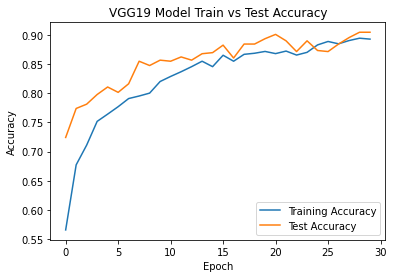

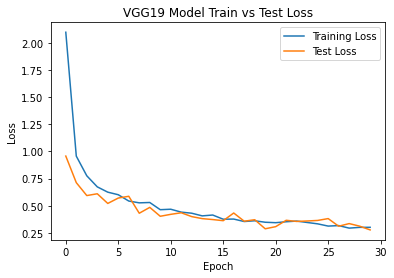

<Figure size 432x288 with 0 Axes>

In [14]:
# evaluate the network
predictions = moodel.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = 30
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG19 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(".\Accuracy_Plot.png")
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG19 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(".\Loss_Plot.png")